### read and plot mesh

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import os

In [2]:
# remove all saved images in the current directory
for file in os.listdir():
    if file.endswith('.png'):
        os.remove(file)

In [3]:
def read_mesh(filename):
    vertices = []
    edges = []
    triangles = []
    with open(filename, 'r') as f:
        lines = f.readlines()
        i = 0
        while i < len(lines):
            line = lines[i].strip()
            if line == "Vertices":
                num_vertices = int(lines[i+1].strip())
                for j in range(num_vertices):
                    parts = lines[i+2+j].strip().split()
                    vertices.append((float(parts[0]), float(parts[1])))
                i += num_vertices + 1
            elif line == "Edges":
                num_edges = int(lines[i+1].strip())
                for j in range(num_edges):
                    parts = lines[i+2+j].strip().split()
                    edges.append((int(parts[0])-1, int(parts[1])-1))
                i += num_edges + 1
            elif line == "Triangles":
                num_triangles = int(lines[i+1].strip())
                for j in range(num_triangles):
                    parts = lines[i+2+j].strip().split()
                    triangles.append((int(parts[0])-1, int(parts[1])-1, int(parts[2])-1))
                i += num_triangles + 1
            else:
                i += 1
    return np.array(vertices), edges, triangles

In [6]:
def plot_mesh(vertices, edges, triangles, xlim=None, ylim=None):
    k = 4
    plt.figure(figsize=(2*k, 2*k))
    for edge in edges:
        v1, v2 = edge
        plt.plot([vertices[v1][0], vertices[v2][0]], [vertices[v1][1], vertices[v2][1]], 'k-', linewidth = 0.1)
    
    for triangle in triangles:
        t1, t2, t3 = triangle
        plt.plot([vertices[t1][0], vertices[t2][0]], [vertices[t1][1], vertices[t2][1]], 'r-', linewidth=0.5)
        plt.plot([vertices[t2][0], vertices[t3][0]], [vertices[t2][1], vertices[t3][1]], 'r-', linewidth=0.5)
        plt.plot([vertices[t3][0], vertices[t1][0]], [vertices[t3][1], vertices[t1][1]], 'r-', linewidth=0.5)

    # plt.scatter(vertices[:, 0], vertices[:, 1], color='blue', linewidths=0.01)
    plt.xlabel('X')
    plt.ylabel('Y')
    # plt.title('Mesh Plot')
    plt.axis('equal')

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    # save the plot
    plt.savefig('mesh.png', dpi=600)
    plt.show()

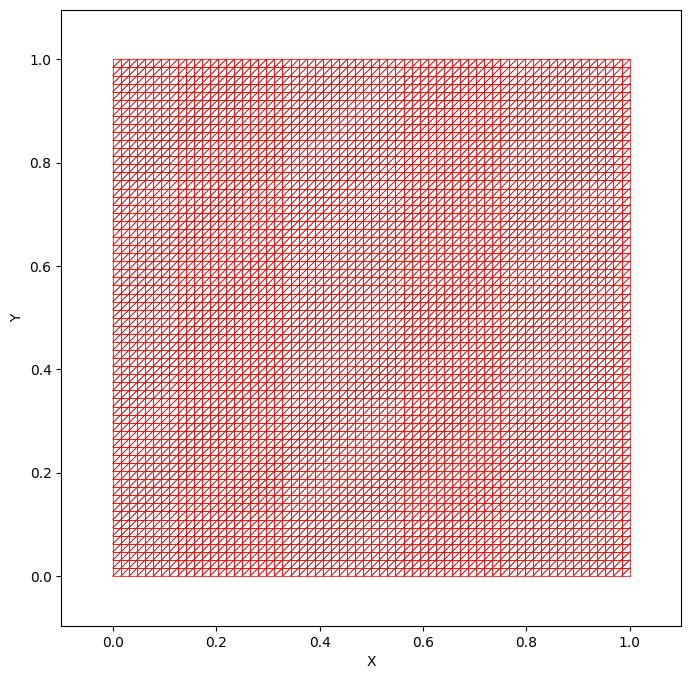

In [7]:
# vertices, edges, triangles = read_mesh('../TestResults/TestCase6/nonConvex1.mesh')
# plot_mesh(vertices, edges, triangles, xlim=(-2.1, 3.1), ylim=(-0.1, 2.1))
# vertices, edges, triangles = read_mesh('../TestResults/TestCase0/unit_square_32.mesh')
# plot_mesh(vertices, edges, triangles, xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))
vertices, edges, triangles = read_mesh('./unit_square_64.mesh')
plot_mesh(vertices, edges, triangles, xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))

### Plot solution

In [ ]:
def read_solution(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    return np.array([float(line.strip()) for line in lines])

In [ ]:
def plot_contour(vertices, triangles, solution, xlim=None, ylim=None):
    k = 4
    plt.figure(figsize=(5*k, 2*k))
    
    # Create the triangulation
    triang = tri.Triangulation(vertices[:, 0], vertices[:, 1], triangles)
    
    # Create the contour plot
    plt.tricontourf(triang, solution, cmap = 'plasma') 
    # cmap='inferno')  
    # cmap = 'jet') 
    # cmap='viridis')
    plt.colorbar(label='Solution value')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Contour Plot')
    plt.axis('equal')

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    
    plt.savefig('TestCase6_solution.png', dpi=600)
    
    plt.show()

In [ ]:
# vertices, edges, triangles = read_mesh('nonConvex1.mesh')
fdaPDE_solution = read_solution('../TestResults/TestCase6/6.0/fdaPDE_SUPG_sol.txt')
plot_contour(vertices, triangles, fdaPDE_solution, xlim=(-2.1, 3.1), ylim=(-0.1, 2.1))

In [ ]:
# vertices, edges, triangles = read_mesh('nonConvex1.mesh')
freeFEM_solution = read_solution('../TestResults/TestCase6/6.0/freeFEM_SUPG_sol.txt')
plot_contour(vertices, triangles, freeFEM_solution, xlim=(-2.1, 3.1), ylim=(-0.1, 2.1))

In [ ]:
diff = np.abs(fdaPDE_solution - freeFEM_solution)
plot_contour(vertices, triangles, diff, xlim=(-2.1, 3.1), ylim=(-0.1, 2.1))

In [ ]:
print(np.linalg.norm(diff, ord = 2))
print(np.max(diff))
print(np.min(diff))

In [ ]:
sol_pert = read_solution('../TestResults/TestCase6/6.0/fdaPDE_SUPG_sol_pert.txt')

### Interpolation at random points

In [ ]:
def sample_random_points(vertices, triangles, num_points):
    x_min, x_max = np.min(vertices[:, 0]), np.max(vertices[:, 0])
    y_min, y_max = np.min(vertices[:, 1]), np.max(vertices[:, 1])
    points = np.zeros((num_points, 2))
    for i in range(num_points):
        while True:
            x, y = np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)
            if is_point_in_mesh(x, y, vertices, triangles):
                points[i, 0] = x
                points[i, 1] = y
                break
    return points

In [ ]:
def is_point_in_mesh(x, y, vertices, triangles):
    for triangle in triangles:
        t1, t2, t3 = vertices[triangle[0]], vertices[triangle[1]], vertices[triangle[2]]
        if is_point_in_triangle(x, y, t1, t2, t3):
            return True
    return False

In [ ]:
def is_point_in_triangle(px, py, p1, p2, p3):
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
    
    d1 = sign((px, py), p1, p2)
    d2 = sign((px, py), p2, p3)
    d3 = sign((px, py), p3, p1)

    has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
    has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)

    return not (has_neg and has_pos)

In [ ]:
def interpolate_solution(vertices, triangles, solution, points):
    triang = tri.Triangulation(vertices[:, 0], vertices[:, 1], triangles)
    interpolator = tri.LinearTriInterpolator(triang, solution)
    interpolated_values = interpolator(points[:, 0], points[:, 1])
    return interpolated_values

In [ ]:
num_points_list = [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300]
for num_points in num_points_list:
    random_points = sample_random_points(vertices, triangles, num_points)
    # interpolated_values = interpolate_solution(vertices, triangles, freeFEM_solution, random_points)
    interpolated_values = interpolate_solution(vertices, triangles, sol_pert, random_points)
    
    plt.figure(figsize=(16, 6))
    triang = tri.Triangulation(vertices[:, 0], vertices[:, 1], triangles)
    plt.tricontourf(triang, sol_pert, cmap='jet')
    plt.colorbar(label='Solution value')
    plt.scatter(random_points[:, 0], random_points[:, 1], c=interpolated_values, cmap='jet', edgecolor='k')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Interpolated Values at Random Points')
    plt.axis('equal')
    # plt.savefig('../../../fdaPDE-cpp/test/data/transport/TransportTestCase6/locs' + str(num_points) + '.png', dpi=600)
    plt.savefig('../Tests_fdaPDE-cpp/TestCase6/' + str(num_points) + '.png', dpi=600)
    plt.show()
    
    row_indices = np.arange(1, num_points + 1)
    column_names = np.array(['', 'x', 'y'])
    random_points = np.column_stack((row_indices, random_points))
    random_points = np.vstack((column_names, random_points))
    np.savetxt('../../fdaPDE-cpp/test/data/transport/TransportTestCase6/locs' + str(num_points) + '.csv', random_points, delimiter=',', fmt='%s')
    
    column_names = np.array(['', 'x'])
    interpolated_values = np.column_stack((row_indices, interpolated_values))
    interpolated_values = np.vstack((column_names, interpolated_values))
    np.savetxt('../../fdaPDE-cpp/test/data/transport/TransportTestCase6/observations' + str(num_points) + '.csv', interpolated_values, delimiter=',', fmt='%s')

#### Interpolation on a Regular Lattice

In [ ]:
def generate_regular_lattice_points(vertices, triangles, num_points_x):
    x_min, x_max = np.min(vertices[:, 0]), np.max(vertices[:, 0])
    y_min, y_max = np.min(vertices[:, 1]), np.max(vertices[:, 1])
    
    x = np.linspace(x_min, x_max, num_points_x)
    y = np.linspace(y_min, y_max, int(num_points_x*2/5))
    xx, yy = np.meshgrid(x, y)
    
    points = np.c_[xx.ravel(), yy.ravel()]
    
    # Filter out points that are outside the mesh
    inside_points = np.array([p for p in points if is_point_in_mesh(p[0], p[1], vertices, triangles)])
    
    return inside_points

In [ ]:
num_points_list = [10, 15, 20, 25, 30, 35] #, 40, 45, 50]
for num_points_x in num_points_list:
    regular_points = generate_regular_lattice_points(vertices, triangles, num_points_x)
    print(regular_points.shape)

In [ ]:
# num_points_x = 20
for num_points_x in num_points_list:
    regular_points = generate_regular_lattice_points(vertices, triangles, num_points_x)
    interpolated_values = interpolate_solution(vertices, triangles, sol_pert, regular_points)
    
    plt.figure(figsize=(10, 5))
    triang = tri.Triangulation(vertices[:, 0], vertices[:, 1], triangles)
    plt.tricontourf(triang, sol_pert, cmap='jet')
    plt.colorbar(label='Solution value')
    plt.scatter(regular_points[:, 0], regular_points[:, 1], c=interpolated_values, cmap='jet', edgecolor='k')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Interpolated Values at Regular Lattice Points')
    plt.axis('equal')
    plt.savefig('../Tests_fdaPDE-cpp/TestCase6/' + str(num_points_x) + '_grid.png', dpi=600)
    plt.show()
    
    row_indices = np.arange(1,  regular_points.shape[0] + 1) #num_points_x + 1)
    column_names = np.array(['', 'x', 'y'])
    regular_points = np.column_stack((row_indices, regular_points))
    regular_points = np.vstack((column_names, regular_points))
    np.savetxt('../../fdaPDE-cpp/test/data/transport/TransportTestCase6/locs' + str(num_points_x) + '.csv', regular_points, delimiter=',', fmt='%s')
    
    column_names = np.array(['', 'x'])
    interpolated_values = np.column_stack((row_indices, interpolated_values))
    interpolated_values = np.vstack((column_names, interpolated_values))
    np.savetxt('../../fdaPDE-cpp/test/data/transport/TransportTestCase6/observations' + str(num_points_x) + '.csv', interpolated_values, delimiter=',', fmt='%s')

### Draw Vector field

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the vector field
def vector_field(x, y):
#     u = k*np.sin(0.1*x+2)
#     v = -y
    v = np.log(x+5)
    u = -(y+1)
    return u, v

# Create a grid of points
x = np.linspace(-2, 3, 20)
y = np.linspace(0, 2, 20)
X, Y = np.meshgrid(x, y)

# Compute the vector field at each grid point
U, V = vector_field(X, Y)

# Plot the vector field
k = 3
plt.figure(figsize=(5*k, 2*k))
plt.quiver(X, Y, U, V, color='r')
plt.title('Transport Vector Field b')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-2, 3)
plt.ylim(0, 2)
plt.grid()
plt.savefig('vector_field_testcase_6.png', dpi=600)
plt.show()

In [ ]:
#original

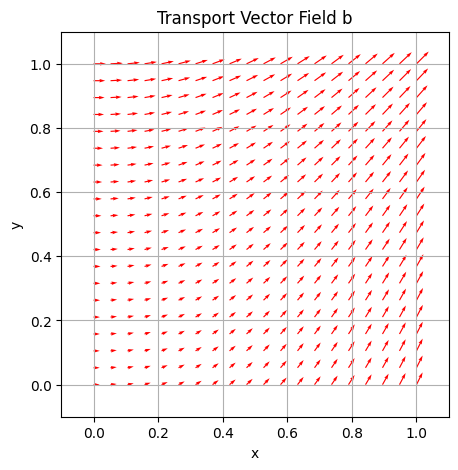

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def vector_field(x, y):
    u = y**2 + 1
    v = 2*x
    return u, v

x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)
U, V = vector_field(X, Y)

k = 5
plt.figure(figsize=(k, k))
plt.quiver(X, Y, U, V, color='r')
plt.title('Transport Vector Field b')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.grid()
plt.savefig('vector_field_testcase_2.png', dpi=600)
plt.show()

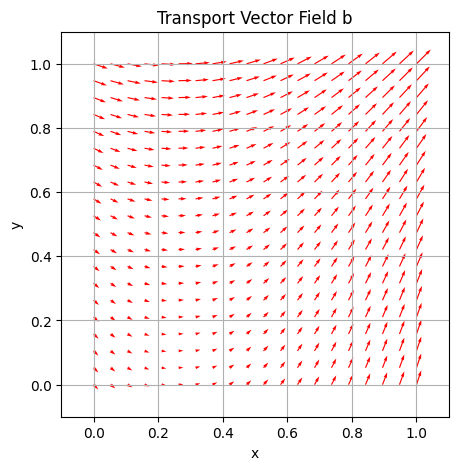

In [9]:
`